In [224]:
# description       : SMS spam classification (Text based)
# ML Models used    : Naive bayes
# author            : raulsainz
# email             : 
# date              : 20210330
# version           : 0.1
#==============================================================================

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB #It should be used for features in decimal form. GNB assumes features to follow a normal distribution
from sklearn.naive_bayes import BernoulliNB #It should be used for features with binary or boolean values like True/False or 0/1.
from sklearn.naive_bayes import MultinomialNB #It should be used for the features with discrete values like word count 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
import string
import nltk #provides a set of diverse natural languages algorithms, used for tokenizing
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from yellowbrick.text import FreqDistVisualizer
from nltk.probability import FreqDist

* *Bernoulli Naive Bayes* : It assumes that all our features are binary such that they take only two values. Means 0s can represent “word does not occur in the document” and 1s as "word occurs in the document" .

* *Multinomial Naive Bayes* : Its is used when we have discrete data (e.g. movie ratings ranging 1 and 5 as each rating will have certain frequency to represent). In text learning we have the count of each word to predict the class or label.

* *Gaussian Naive Bayes* : Because of the assumption of the normal distribution, Gaussian Naive Bayes is used in cases when all our features are continuous. For example in Iris dataset features are sepal width, petal width, sepal length, petal length. So its features can have different values in data set as width and length can vary. We can’t represent features in terms of their occurrences. This means data is continuous. Hence we use Gaussian Naive Bayes here.

In [54]:
#Setup pandas display parameters
pd.options.display.max_columns = 50
pd.options.display.max_rows = 200
pd.options.display.max_colwidth= 100
pd.options.display.precision = 3

In [55]:
#Define initial model parameters
cv_n_split = 3
random_state = 42
test_train_split = 0.25

In [56]:
# Create empty list with models results
model_results = []

In [57]:
df = pd.read_csv('datasets/sms_spam.csv')

In [58]:
df.shape

(5574, 2)

In [59]:
df.head()

,type,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there g..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive ...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [60]:
#Check for null values on all columns
df.isnull().sum(axis = 0)

type    0
text    0
dtype: int64

In [61]:
df['type'].value_counts(normalize=True)

ham     0.866
spam    0.134
Name: type, dtype: float64

<AxesSubplot:>

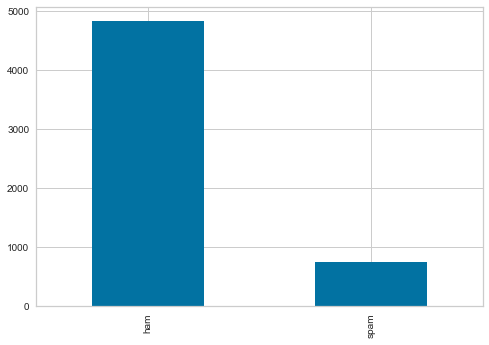

In [62]:
df['type'].value_counts().plot(kind='bar')

In [63]:
#Set Targed variable as category
df['type'] = df['type'].astype('category')


In [64]:
df.dtypes

type    category
text      object
dtype: object

In [65]:
# To Lower
df['text'] = df['text'].str.lower()
df.head()

,type,text
0,ham,"go until jurong point, crazy.. available only in bugis n great world la e buffet... cine there g..."
1,ham,ok lar... joking wif u oni...
2,spam,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005. text fa to 87121 to receive ...
3,ham,u dun say so early hor... u c already then say...
4,ham,"nah i don't think he goes to usf, he lives around here though"


In [66]:
#Striping punctuation
df['text'] = df['text'].str.replace('[{}]'.format(string.punctuation), '') # Removes punctuation
df['text'] = df['text'].str.replace('\\'.format(string.punctuation), ' ') # Removes backslash
df.head()

/Users/raulsainz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  
/Users/raulsainz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  This is separate from the ipykernel package so we can avoid doing imports until


,type,text
0,ham,go until jurong point crazy available only in bugis n great world la e buffet cine there got amo...
1,ham,ok lar joking wif u oni
2,spam,free entry in 2 a wkly comp to win fa cup final tkts 21st may 2005 text fa to 87121 to receive e...
3,ham,u dun say so early hor u c already then say
4,ham,nah i dont think he goes to usf he lives around here though


In [67]:
df['text'] = df['text'].str.replace('[0-9]'.format(string.punctuation), '') # Removes Numbers

/Users/raulsainz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [68]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [69]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()
stop  = lambda word: word not in stop_words
steam = lambda word: stemmer.stem(word)
def mytokenizer(sentence):
    tokens = word_tokenize(sentence)
    #print(tokens)
    new = list(filter(stop, tokens)) #remove english stop words
    new = list(map(steam, new)) #steam words
    return new

In [70]:
# Full document-term matrix for text
cv = CountVectorizer(tokenizer=mytokenizer)
tdm_text = cv.fit_transform(df.text) #Get bag of words for title
text_names = cv.get_feature_names() # Get feature names

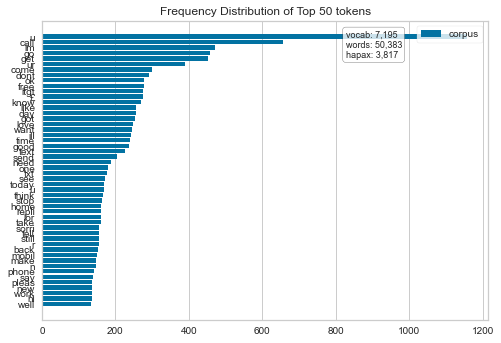

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [71]:
#fdist = FreqDist(bow_title)
visualizer = FreqDistVisualizer(features=text_names, orient='h')
visualizer.fit(tdm_text)
visualizer.show()

In [72]:
# Create Document Matrix
DocumentMatrix_text = pd.DataFrame(tdm_text.toarray(), columns=text_names)
print(DocumentMatrix_text.shape)

(5574, 7195)


In [73]:
DocumentMatrix_text.us.unique()

array([0, 1, 2, 3])

# Model #1 - Multinomial NB

In [74]:
#Split the data into DV and IV's
X = DocumentMatrix_text
y = df['type']
print(X.shape)
print(y.shape)


(5574, 7195)
(5574,)


In [75]:
#split into raining and test
X_train,X_test, y_train,y_test = train_test_split(X,y,random_state=random_state)

In [76]:
X_train.shape

(4180, 7195)

Accuracy = 0.9677187948350072
ROC_AUC = 0.954870676711363
              precision    recall  f1-score   support

         ham    0.98985   0.97257   0.98113      1203
        spam    0.84434   0.93717   0.88834       191

    accuracy                        0.96772      1394
   macro avg    0.91709   0.95487   0.93473      1394
weighted avg    0.96991   0.96772   0.96842      1394



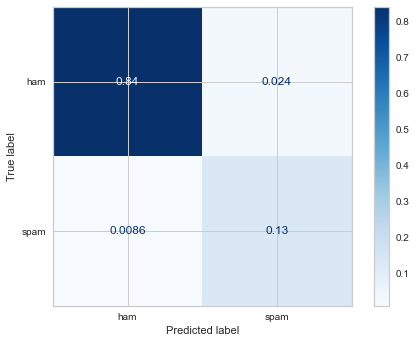

In [80]:
#Create a Multinomial Naive Bayes Classifier
model_nb1 = MultinomialNB()
model_rf, roc_auc_rf = run_model(model_nb1, X_train, y_train, X_test, y_test,desc='MultinomialNB - Title')

# Model #2 - Bernoulli NB

In [40]:
DocumentMatrix_text.sum().sort_values(ascending=False)

u          1157
call        657
im          471
go          456
get         451
           ... 
kaypoh        1
kath          1
katexxx       1
karo          1
…thank        1
Length: 7195, dtype: int64

In [81]:
#Transform  word counts into bool
DocumentMatrix_text_bool = DocumentMatrix_text.apply(lambda x: [True if y >0 else False for y in x])
DocumentMatrix_text_bool.head()

,aa,aah,aaniy,aaooooright,aathilov,aathiwher,ab,abbey,abdomen,abeg,abelu,aberdeen,abi,abil,abiola,abj,abl,abnorm,abouta,abroad,absenc,absolut,abstract,abt,abta,...,£k,£million,£minmobsmorelkpoboxhpfl,£month,£morefrmmob,£msg,£p,£perweeksub,£perwksub,£pm,£pmmorefrommobilebremovedmobypoboxlsyf,£s,£week,£wk,££,»,é,ü,üll,–,‘,’,“,…,…thank
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


(5574, 7195)
(5574,)
Accuracy = 0.9677187948350072
ROC_AUC = 0.9042206873740605
              precision    recall  f1-score   support

         ham    0.97150   0.99169   0.98149      1203
        spam    0.93976   0.81675   0.87395       191

    accuracy                        0.96772      1394
   macro avg    0.95563   0.90422   0.92772      1394
weighted avg    0.96715   0.96772   0.96675      1394



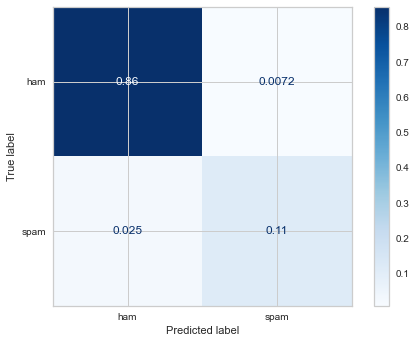

In [82]:
#Split the data into DV and IV's
X = DocumentMatrix_text_bool
y = df['type']
print(X.shape)
print(y.shape)
#split into raining and test
X_train,X_test, y_train,y_test = train_test_split(X,y,random_state=random_state)
#Create a Gaussian Classifier
model_nb3 = BernoulliNB()
model_rf, roc_auc_rf = run_model(model_nb3, X_train, y_train, X_test, y_test,desc='BernoulliNB - Title')

In [39]:
df.dtypes

type    category
text      object
dtype: object

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf = TfidfVectorizer(stop_words = stop_words)
trans  = tf_idf.fit_transform(df.text)
idf = pd.DataFrame(trans.toarray(),columns = tf_idf.get_feature_names())

In [26]:
len(tf_idf.get_feature_names())

8478

In [27]:
tf_idf.get_feature_names()[2000:2010]

['dream',
 'dreamlove',
 'dreams',
 'dreamsmuah',
 'dreamstake',
 'dreamsu',
 'dreamz',
 'dress',
 'dressed',
 'dresser']

In [21]:
idf.head(20)

,aa,aah,aaniye,aaooooright,aathilove,aathiwhere,ab,abbey,abdomen,abeg,abelu,aberdeen,abi,ability,abiola,abj,able,abnormally,aboutas,abroad,absence,absolutely,abstract,abt,abta,...,yummy,yun,yunny,yuo,yuou,yup,yupz,ywhere,zac,zahers,zealand,zebra,zed,zeros,zf,zhong,zindgi,zoe,zogtorius,zoom,zouk,zs,zyada,üll,〨ud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
#Split the data into DV and IV's
X = idf
y = df['type']
print(X.shape)
print(y.shape)
#split into raining and test
X_train,X_test, y_train,y_test = train_test_split(X,y,random_state=random_state)

(5574, 8478)
(5574,)


Accuracy = 0.9677187948350072
ROC_AUC = 0.9042206873740605
              precision    recall  f1-score   support

         ham    0.97150   0.99169   0.98149      1203
        spam    0.93976   0.81675   0.87395       191

    accuracy                        0.96772      1394
   macro avg    0.95563   0.90422   0.92772      1394
weighted avg    0.96715   0.96772   0.96675      1394



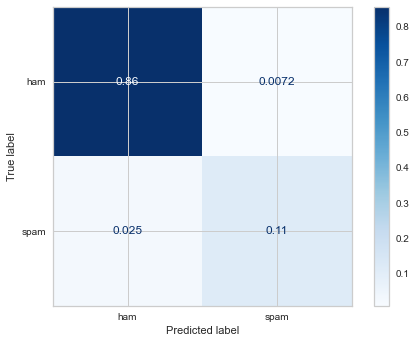

In [83]:

#Run a Gaussian Classifier
model_rf, roc_auc_rf = run_model(BernoulliNB(), X_train, y_train, X_test, y_test,desc='BernoulliNB - TF-IDF')

In [ ]:
#Run a  MultinomialNB classifier
model_rf, roc_auc_rf = run_model(MultinomialNB(), X_train, y_train, X_test, y_test,desc='BernoulliNB - TF-IDF')

In [84]:
def run_model(model, X_train, y_train, X_test, y_test, verbose=True,desc='myModel'):
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test) #Predict the response for test dataset
    roc_auc = multi_roc_auc_score(y_test, y_pred)
    model_acc = metrics.accuracy_score(y_test, y_pred )  # Model Accuracy, how often is the classifier correct?
    print("Accuracy = {}".format(model_acc))   
    print("ROC_AUC = {}".format(roc_auc))
    print(classification_report(y_test,y_pred,digits=5))
    plot_confusion_matrix(model, X_test, y_test,cmap=plt.cm.Blues, normalize = 'all')
    model_results.append({'Model':desc,'ROC_AUC':roc_auc,'Acuracy':model_acc})
    return model, roc_auc

In [79]:
def multi_roc_auc_score(y_test,y_pred,average='macro'):
    labels = preprocessing.LabelBinarizer()
    labels.fit(y_test)
    y_test = labels.transform(y_test)
    y_pred = labels.transform(y_pred)
    return roc_auc_score(y_test, y_pred,average=average)